In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

image_size = (180, 180)
batch_size = 32
epochs = 60

train_ds, val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "..\images\Massas",
    validation_split=0.3,
    subset="both",
    color_mode="rgb",
    seed=1212,
    image_size=image_size,
    batch_size=batch_size,
)


data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)


# ## Build a model

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

model = make_model(input_shape=image_size + (3,), num_classes=2)

# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)

# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)


# ## Train the model

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

Found 1696 files belonging to 2 classes.
Using 1188 files for training.
Using 508 files for validation.


In [4]:
history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
)

Epoch 1/60
38/38 [==============================] - 101s 3s/step - loss: 0.0758 - accuracy: 0.9689 - val_loss: 0.7411 - val_accuracy: 0.3799
Epoch 2/60
38/38 [==============================] - 101s 3s/step - loss: 0.0196 - accuracy: 0.9958 - val_loss: 0.8723 - val_accuracy: 0.3799
Epoch 3/60
38/38 [==============================] - 101s 3s/step - loss: 0.0147 - accuracy: 0.9949 - val_loss: 0.9965 - val_accuracy: 0.3799
Epoch 4/60
38/38 [==============================] - 101s 3s/step - loss: 0.0179 - accuracy: 0.9958 - val_loss: 1.7000 - val_accuracy: 0.3799
Epoch 5/60
38/38 [==============================] - 102s 3s/step - loss: 0.0185 - accuracy: 0.9941 - val_loss: 2.0388 - val_accuracy: 0.3799
Epoch 6/60
38/38 [==============================] - 102s 3s/step - loss: 0.0098 - accuracy: 0.9966 - val_loss: 1.9697 - val_accuracy: 0.3799
Epoch 7/60
38/38 [==============================] - 103s 3s/step - loss: 0.0074 - accuracy: 0.9975 - val_loss: 2.2764 - val_accuracy: 0.3799
Epoch 8/60
38

38/38 [==============================] - 102s 3s/step - loss: 0.0040 - accuracy: 0.9983 - val_loss: 0.0505 - val_accuracy: 0.9882
Epoch 59/60
38/38 [==============================] - 102s 3s/step - loss: 0.0035 - accuracy: 0.9983 - val_loss: 0.0115 - val_accuracy: 0.9921
Epoch 60/60
38/38 [==============================] - 101s 3s/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.0110 - val_accuracy: 0.9941


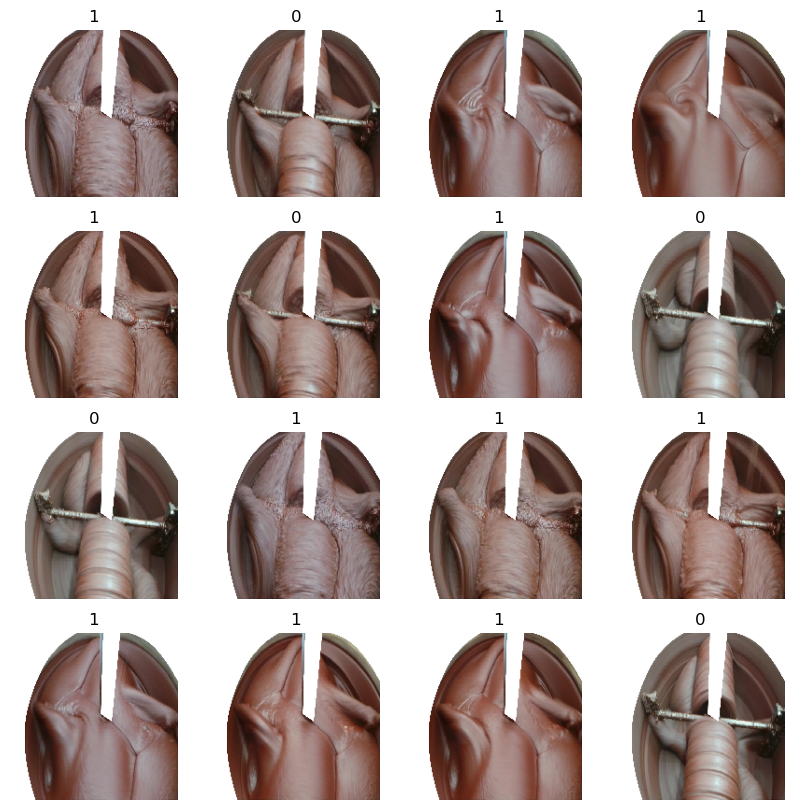

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [6]:
import pandas as pd
import numpy as np

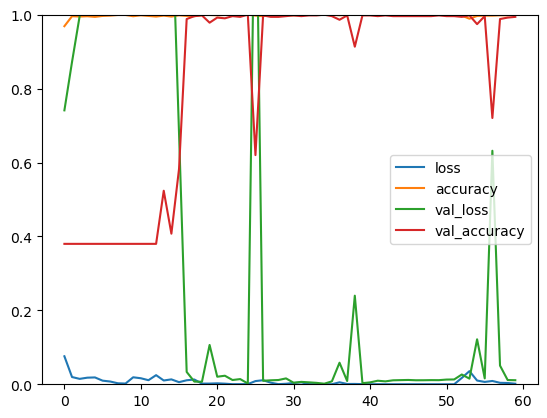

In [7]:
historydf = pd.DataFrame(history.history, index=history.epoch)
learning_curve = historydf.plot(ylim=(0,1))

In [8]:
model.evaluate(val_ds)

16/16 [==============================] - 11s 650ms/step - loss: 0.0110 - accuracy: 0.9941


[0.01099502481520176, 0.9940944910049438]

In [9]:
from sklearn.metrics import confusion_matrix

In [10]:
y_pred = model.predict(val_ds)

16/16 [==============================] - 11s 652ms/step


In [11]:
y_pred_class = y_pred > 0.5
y_pred_class = np.array(y_pred_class)
y_pred_class = np.reshape(y_pred_class, (508,))
print(y_pred_class.shape)

y = np.concatenate([y for x, y in val_ds], axis=0)
y = np.array(y)
print(y.shape)

(508,)
(508,)


In [12]:
def pretty_confusion_matrix(y_true, y_pred, labels=["False", "True"]):
    cm = confusion_matrix(y_true, y_pred)
    pred_labels = ['Julgou '+ l for l in labels]
    df = pd.DataFrame(cm, index=labels, columns=pred_labels)
    return df

pretty_confusion_matrix(y, y_pred_class, ['Pronto', 'Não pronto'])

,Julgou Pronto,Julgou Não pronto
Pronto,314,1
Não pronto,2,191


In [21]:
model.save("trained_model_60epochs")

INFO:tensorflow:Assets written to: trained_model_60epochs\assets


INFO:tensorflow:Assets written to: trained_model_60epochs\assets
